# INDEX

-  [MODELING, loadING, EVOLVING](#modeling-loading-evolving)

    1. [Modeling](#modeling)

    2. [loading](#loading)

    3. [Evolving](#evolving)

- [QUERYING](#querying)
    
    1. [Query 1](#query-1:-find-the-top-3-most-cited-papers-of-each-conference.)

    2. [Query 2](#query-2:-for-each-conference-find-its-community:-i.e.,-those-authors-that-have-published-papers-on-that-conference-in,-at-least,-4-different-editions.)

    3. [Query 3](#query-3:-find-the-impact-factors-of-the-journals-in-your-graph.)

    4. [Query 4](#query-4:-find-the-h-indexes-of-the-authors-in-your-graph.)

# IMPORTS

In [347]:
from faker import Faker
import random
import json
import pandas as pd
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [348]:
def int_to_roman(num):
    if not (isinstance(num, int) or isinstance(num, float)):
        raise TypeError("Input must be an integer or float")
    
    num = int(round(num, 0))
    
    if not (1 <= num <= 50):
        raise ValueError("Number out of range (must be between 1 and 50)")
    
    val = [
        50, 40, 10, 9, 5, 4, 1
    ]
    syb = [
        "L", "XL", "X", "IX", "V", "IV", "I"
    ]
    roman_num = ''
    i = 0
    while  num > 0:
        for _ in range(num // val[i]):
            roman_num += syb[i]
            num -= val[i]
        i += 1
    return roman_num

In [349]:
uri = "bolt://localhost:7687"
user = "neo4j"
password = "gwaB$3DMlab2"

driver = GraphDatabase.driver(uri, auth=(user, password))

# MODELING, LOADING, EVOLVING

[Back to Index](#INDEX)

## Modeling

[Back to Index](#INDEX)

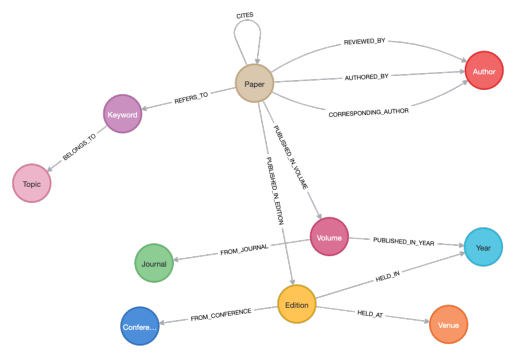

In [350]:
conceptual_graph = mpimg.imread('graph.png')
plt.imshow(conceptual_graph)
plt.axis('off')
plt.show()

Additionally to the nodes and relationships, we have additional attributes, as follows:
- Paper: title, abstract, number of pages, year of publication (which coincides with the year of the conference or journal in which it was published), DOI number.
- Author: name, affiliation.
- Keyword: keyword.
- Topic: topic name.
- Conference: general name of the conference.
- Journal: name of the journal.
- Edition: edition full name (with number), number of attendees, location/venue, number of pages of the proceedings for the specific edition (which is the sum of the pages of all the papers in that edition).
- Volume: volume number, year of publication, number of pages of the volume (which is the sum of the pages of all the papers in that volume).
- Year: year number.
- Venue: name of the venue (all major cities in the world).

The configuration we created relates each paper to its authors, corresponding authors and to its reviewers (with different relations). This way, we can easily query for all the people who participated in the publication of the paper. We also relate each paper with the other papers it cites to allow for smooth querying of number of references between papers. Finally, if anyone is interested in getting information about the citations of a paper, we can easily query for it using our configuration. Each keyword is additionally related to the topic to which it refers, in order to allow for easy querying for the topics of each paper.
We relate each paper to either the volume of a journal or the edition of a conference/workshop in which it was published. This way, it's fast to query for papers published in each edition or volume or even to know which authors published in each one of those. We can also easily query for the amount of papers published by an author in a given journal because we also relate each edition to their specific conference/workshop and each volume to the journal it belongs to (instead of storing this type of information inside of the attributes of each edition/volume, case in which the querying would be slower and less efficient). 
Finally, information about the year of publication of a volume/edition and the city in which a conference/workshop took place is also stored in the database using separate nodes and relations for each. This way, we can effortlessly relate which topics have been talked about in a given city or which authors published in a given year. 

We used this configuration of the database to ensure maximum that enough nodes were created so that additional information can be related to the database. For example, it could have been easier to just store information about the year of publication of the volumes and Editions' proceedings as attributes to each node but this would have made it harder afterwards to add new nodes which might need to also be related to years. Maybe we could need to include a relation about the year when a topic was first introduced. In this case, it would be very easy as we just need to create the relation from each topic to their respective year.

Non-essential information is included only as attributes so even if we don't know the exact number of attendees for a given edition, we can still enter the rest of the information about that edition without needing to create a low confidence relation from it which would show in the queries.

Regarding part B, we can easily count the amount of citations of the papers of each conference, we can also easily count the amount of times that each author appears as the author of papers published in a given conference. We can also pretty easily get the total amount of citations received by the papers published in a given journal and the amount of papers published there as well. Regarding the h-index, it is even easier as we can very easily relate the papers to each author and count their citations in order to compute the h-index.

## Loading

[Back to Index](#INDEX)

In [351]:
random.seed(168)

faker = Faker()

num_authors = 100
num_papers = 200
num_conferences = 5
num_journals = 3
num_topics = 10
num_keywords = 50
num_reviews_per_paper = 3
num_venues = 20
num_years = 50

In [352]:
# Generate Authors
authors = [
    {
        "name": faker.name(),
        "affiliation": faker.company()
    }
    for _ in range(num_authors)
]

# Generate Topics and Keywords
topics = [{"topic": topic} for topic in [
    "Machine Learning",
    "Natural Language Processing",
    "Computer Vision",
    "Reinforcement Learning",
    "Robotics",
    "Data Mining",
    "Database Management",
    "Neural Networks",
    "Time-Series Analysis",
    "Software Engineering"
]]

keywords = []
for topic in topics:
    for _ in range(5):
        keywords.append({"word": faker.word(), "topic": topic["topic"]})

# Generate Venues
cities = [
    "New York",
    "London",
    "Tokyo",
    "Paris",
    "Sydney",
    "Toronto",
    "Berlin",
    "Singapore",
    "Hong Kong",
    "Dubai",
    "Los Angeles",
    "Barcelona",
    "Moscow",
    "São Paulo",
    "Johannesburg",
    "Rome",
    "Istanbul",
    "Beijing",
    "Mumbai",
    "Buenos Aires"
]

venues = [{"city": city} for city in cities]

# Generate Years
years = [{"year": str(year)} for year in range(2024 - num_years, 2024)]

# Generate Papers
papers = []
for _ in range(num_papers):
    num_authors_per_paper = random.randint(2, 5)
    list_of_authors_names = [author["name"] for author in authors]
    author_list = random.sample(list_of_authors_names  , k = num_authors_per_paper)
    corresponding_author = random.choice(author_list)
    author_list.remove(corresponding_author)
    num_keywords_per_paper = random.randint(3, 7)
    keyword_list = random.sample(keywords, k=num_keywords_per_paper)
    
    # list_of_years = [year["year"] for year in years]
    # year_paper = random.choice(list_of_years)
    
    # prefix = "https://doi.org/"
    # directory = random.randint(10, 99)
    # journal_number = random.randint(1000000, 9999999)
    # article_number = random.randint(1000000, 9999999)
    
    paper = {
        "title": faker.sentence(nb_words=6),
        "abstract": faker.paragraph(nb_sentences=5),
        # "year": year_paper,
        "pages": random.randint(5, 35),
        # "DOI": f"{prefix}{directory}.{journal_number}.{year_paper}.{article_number}",
        "authors": author_list,
        "corresponding_author": corresponding_author,
        "keywords": keyword_list
    }
    papers.append(paper)

# Generate Conferences and Editions
conferences = [{"name": f"Conference of {faker.word()}"} for _ in range(num_conferences)]

editions = []
for conf in conferences:
    num_editions = random.randint(1, 5)
    starting_year = random.randint(1990, 1974 + num_years - num_editions)
    for i in range(num_editions):
        edition = {
            "conference_name": conf["name"],
            "edition_name": f"{conf["name"]} {int_to_roman(i + 1)}",
            "attendees": random.randint(100, 1000),
            "venue": random.choice(venues)["city"],
            "year": str(starting_year + i),
            "proceedings_pages": 0
        }
        editions.append(edition)

# Generate Journals and Volumes
journals = [{"name": f"Journal of {faker.word()}"} for _ in range(num_journals)]

volumes = []
for journal in journals:
    num_volumes = random.randint(2, 5)
    starting_year = random.randint(1990, 1974 + num_years - num_volumes)
    for i in range(num_volumes):
        volume = {
            "journal_name": journal["name"],
            "volume_number": f"{journal["name"]} vol. {int_to_roman(i + 1)}",
            "year": str(starting_year + i),
            "volume_pages": 0
        }
        volumes.append(volume)

# Assign Papers to editions or volumes
containers = editions + volumes
random.shuffle(containers)
num_containers = len(containers)
container_papers = {i: [] for i in range(num_containers)}

for i, paper in enumerate(papers):
    container_index = i % num_containers
    container = containers[container_index]
    container_papers[container_index].append(paper)
    paper["year"] = container["year"]
    
    prefix = "https://doi.org/"
    directory = random.randint(10, 99)
    journal_number = random.randint(1000000, 9999999)
    article_number = random.randint(1000000, 9999999)
    
    paper["DOI"] = f"{prefix}{directory}.{journal_number}.{paper["year"]}.{article_number}"
    
    if "conference_name" in container:
        paper["published_in"] = container["edition_name"]
    else:
        paper["published_in"] = container["volume_number"]

for container_index, p in container_papers.items():
    container = containers[container_index]
    total_pages = sum(paper["pages"] for paper in p)
    if "conference_name" in container:
        container["proceedings_pages"] = total_pages
    else:
        container["volume_pages"] = total_pages

# Generate Reviews as Relationships
reviews = []
for paper in papers:
    eligible_reviewers = [author for author in authors if author["name"] not in paper["authors"]]
    reviewers = random.sample(eligible_reviewers, k=num_reviews_per_paper)
    for reviewer in reviewers:
        review = {
            "paper_DOI": paper["DOI"],
            "reviewer_name": reviewer["name"]
        }
        reviews.append(review)

# Generate Citations for the Papers 
for paper in papers:
    num_citations = random.randint(5, 15)
    citations = random.sample(papers, k=num_citations)
    paper["citations"] = [citation["DOI"] for citation in citations]

In [353]:
data = {
    "authors": authors,
    "papers": papers,
    "conferences": conferences,
    "editions": editions,
    "journals": journals,
    "volumes": volumes,
    "keywords": keywords,
    "topics": topics,
    "reviews": reviews,
    "venues": venues,
    "years": years
}

# Save to json file for safekeeping
with open("faked_data.json", "w") as f:
    json.dump(data, f, indent=4)

print("Faked data generated and saved to faked_data.json")

Faked data generated and saved to faked_data.json


In [354]:
""" we convert the json file to csv and we store it in the folder of the imports for the neo4j database """

pathname_import = "/Users/guillemmirabentrubinat/Library/Application Support/Neo4j Desktop/Application/relate-data/dbmss/dbms-85682a6c-ffc5-4848-8ae3-81bf5af53bcf/import"

# Save authors
pd.DataFrame(data['authors']).to_csv(f'{pathname_import}/authors.csv', index=False)

# Save topics
pd.DataFrame(data['topics']).to_csv(f'{pathname_import}/topics.csv', index=False)

# Save keywords
df_keywords = pd.DataFrame(data['keywords'])
df_keywords.to_csv(f'{pathname_import}/keywords.csv', index=False)

# Save venues
pd.DataFrame(data['venues']).to_csv(f'{pathname_import}/venues.csv', index=False)

# Save years
df_years = pd.DataFrame(data['years'])
df_years['year'] = df_years['year'].astype(int)
df_years.to_csv(f'{pathname_import}/years.csv', index=False)

# Save papers
df_papers = pd.DataFrame(data['papers'])
df_papers['pages'] = df_papers['pages'].astype(int)
df_papers['year'] = df_papers['year'].astype(int)
df_papers.to_csv(f'{pathname_import}/papers.csv', index=False)

# Save paper authors
paper_authors = []
for paper in data['papers']:
    for author in paper['authors']:
        paper_authors.append({'DOI': paper['DOI'], 'author_name': author})
pd.DataFrame(paper_authors).to_csv(f'{pathname_import}/paper_authors.csv', index=False)

# Save paper publications
paper_editions = []
paper_volumes = []
for paper in data['papers']:
    if 'Conference' in paper['published_in']:
        paper_editions.append({'DOI': paper['DOI'], 'edition': paper['published_in']})
    else:
        paper_volumes.append({'DOI': paper['DOI'], 'volume': paper['published_in']})
pd.DataFrame(paper_editions).to_csv(f'{pathname_import}/paper_editions.csv', index=False)
pd.DataFrame(paper_volumes).to_csv(f'{pathname_import}/paper_volumes.csv', index=False)

# Save paper citations
paper_citations = []
for paper in data['papers']:
    for citation in paper['citations']:
        paper_citations.append({'DOI': paper['DOI'], 'cited_DOI': citation})
pd.DataFrame(paper_citations).to_csv(f'{pathname_import}/paper_citations.csv', index=False)

# paper_corresponding_authors = []
# for paper in data['papers']:
#     paper_corresponding_authors.append({'DOI': paper['DOI'], 'corresponding_author': paper['corresponding_author']})
# pd.DataFrame(paper_corresponding_authors).to_csv(f'{pathname_import}/paper_corresponding_authors.csv', index=False)

# Save paper keywords
paper_keywords = []
for paper in data['papers']:
    for keyword in paper['keywords']:
        paper_keywords.append({'DOI': paper['DOI'], 'keyword': keyword['word']})
pd.DataFrame(paper_keywords).to_csv(f'{pathname_import}/paper_keywords.csv', index=False)

# Save conferences
pd.DataFrame(data['conferences']).to_csv(f'{pathname_import}/conferences.csv', index=False)

# Save editions
df_editions = pd.DataFrame(data['editions'])
df_editions['year'] = df_editions['year'].astype(int)
df_editions['attendees'] = df_editions['attendees'].astype(int)
df_editions['proceedings_pages'] = df_editions['proceedings_pages'].astype(int)
df_editions.to_csv(f'{pathname_import}/editions.csv', index=False)

# Save journals
pd.DataFrame(data['journals']).to_csv(f'{pathname_import}/journals.csv', index=False)

# Save volumes
df_volumes = pd.DataFrame(data['volumes'])
df_volumes['year'] = df_volumes['year'].astype(int)
df_volumes['volume_pages'] = df_volumes['volume_pages'].astype(int)
df_volumes.to_csv(f'{pathname_import}/volumes.csv', index=False)

# Save reviews
df_reviews = pd.DataFrame(data['reviews'])
df_reviews.to_csv(f'{pathname_import}/reviews.csv', index=False)

In [355]:
def clear_database(tx):
    tx.run("MATCH (n) DETACH DELETE n")

def load_data(tx):
    # Load Authors
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///authors.csv' AS row
    CREATE (:Author {author_name: row.name, affiliation: row.affiliation});
    """)

    # Load Topics
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///topics.csv' AS row
    CREATE (:Topic {topic: row.topic});
    """)

    # Load Keywords
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///keywords.csv' AS row
    MATCH (t:Topic {topic: row.topic})
    CREATE (k:Keyword {keyword: row.word})-[:BELONGS_TO]->(t);
    """)

    # Load Venues
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///venues.csv' AS row
    CREATE (:Venue {city: row.city});
    """)

    # Load Years
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///years.csv' AS row
    CREATE (:Year {year: row.year});
    """)
    
    # Load Conferences
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///conferences.csv' AS row
    CREATE (:Conference {conference_name: row.name});
    """)

    # Load Journals
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///journals.csv' AS row
    CREATE (:Journal {journal_name: row.name});
    """)

    # Load Editions
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///editions.csv' AS row
    MATCH (c:Conference {conference_name: row.conference_name})
    MATCH (v:Venue {city: row.venue})
    MATCH (y:Year {year: row.year})
    CREATE (e:Edition {edition_name: row.edition_name, attendees: row.attendees, proceedings_pages: row.proceedings_pages})
    CREATE (e)-[:HELD_AT]->(v)
    CREATE (e)-[:HELD_IN]->(y)
    CREATE (e)-[:FROM_CONFERENCE]->(c);
    """)

    # Load Volumes
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///volumes.csv' AS row
    MATCH (j:Journal {journal_name: row.journal_name})
    MATCH (y:Year {year: row.year})
    CREATE (v:Volume {volume_name: row.volume_number, volume_pages: row.volume_pages})
    CREATE (v)-[:PUBLISHED_IN_YEAR]->(y)
    CREATE (v)-[:FROM_JOURNAL]->(j);
    """)

    # Load Papers
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///papers.csv' AS row
    MATCH (a:Author {author_name: row.corresponding_author})
    CREATE (p:Paper {title: row.title, abstract: row.abstract, paper_year: row.year, paper_pages: row.pages, DOI: row.DOI})
    CREATE (p)-[:CORRESPONDING_AUTHOR]->(a);
    """)

    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///paper_authors.csv' AS row
    MATCH (p:Paper {DOI: row.DOI}), (a:Author {author_name: row.author_name})
    CREATE (p)-[:AUTHORED_BY]->(a);
    """)

    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///paper_editions.csv' AS row
    MATCH (p:Paper {DOI: row.DOI}), (e:Edition {edition_name: row.edition})
    CREATE (p)-[:PUBLISHED_IN_EDITION]->(e);
    """)
    
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///paper_volumes.csv' AS row
    MATCH (p:Paper {DOI: row.DOI}), (v:Volume {volume_name: row.volume})
    CREATE (p)-[:PUBLISHED_IN_VOLUME]->(v);
    """)

    # tx.run("""
    # LOAD CSV WITH HEADERS FROM 'file:///paper_corresponding_authors.csv' AS row
    # MATCH (p:Paper {DOI: row.DOI}), (a:Author {name: row.corresponding_author})
    # CREATE (p)-[:CORRESPONDING_AUTHOR]->(a);
    # """)

    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///paper_keywords.csv' AS row
    MATCH (p:Paper {DOI: row.DOI}), (k:Keyword {keyword: row.keyword})
    CREATE (p)-[:REFERS_TO]->(k);
    """)

    # Load Reviews
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///reviews.csv' AS row
    MATCH (p:Paper {DOI: row.paper_DOI}), (a:Author {author_name: row.reviewer_name})
    CREATE (p)-[:REVIEWED_BY]->(a);
    """)
    
    # Load Citations
    tx.run("""
    LOAD CSV WITH HEADERS FROM 'file:///paper_citations.csv' AS row
    MATCH (p:Paper {DOI: row.DOI}), (c:Paper {DOI: row.cited_DOI})
    CREATE (p)-[:CITES]->(c);
    """)

with driver.session() as session:
    session.execute_write(clear_database)
    session.execute_write(load_data)

print("Data loaded into Neo4j")

Data loaded into Neo4j


## Evolving

[Back to Index](#INDEX)

# QUERYING

[Back to Index](#INDEX)

## Query 1: Find the top 3 most cited papers of each conference.

[Back to Index](#INDEX)

## Query 2: For each conference find its community: i.e., those authors that have published papers on that conference in, at least, 4 different editions.

[Back to Index](#INDEX)

## Query 3: Find the impact factors of the journals in your graph.

[Back to Index](#INDEX)

## Query 4: Find the h-indexes of the authors in your graph.

[Back to Index](#INDEX)